In [1]:
import os, sys, time, argparse
import matplotlib.pyplot as plt
import numpy as np
import json
import ray

ray.init(log_to_driver=False)
def load_swarm_data(filename):
    with open(filename) as json_file:
        swarm_data = json.load(json_file)
    # Grab the total number of integrations
    n_data = len(swarm_data)

    
    # 'cal_solution', 'delays', 'efficiencies', 'inputs', 'int_length', 'int_time', 'phases'
    if 'phases' in swarm_data[0].keys():
        # Phases is the "old" keyword, where DSB phasing wasn't used.
        input_count = np.median([len(swarm_data[idx]['inputs']) for idx in range(n_data)])
        use_data = [
            (len(swarm_data[idx]['inputs']) == input_count)
            and (len(swarm_data[idx]['phases']) == input_count)
            and (len(swarm_data[idx]['cal_solution'][2]) == input_count)
            for idx in range(n_data)
        ]

        swarm_data = [swarm_data[idx] for idx in range(n_data) if use_data[idx]]
        n_data = len(swarm_data)

        n_inputs = len(np.unique(np.array([data['inputs'] for data in swarm_data])[:, :, 0]))
        
        # These are the implemented phase values recorded in SWARM
        phase_online = np.array([swarm_data[idx]['phases'] for idx in range(n_data)])
        # These are the derived phase offsets post-correlation
        phase_solns = np.array([swarm_data[idx]['cal_solution'][2] for idx in range(n_data)])
    else:
        input_count = np.median([[len(data['inputs_lsb']), len(data['inputs_usb'])] for data in swarm_data])

        use_data = [
            (len(swarm_data[idx]['inputs_lsb']) == input_count)
            and (len(swarm_data[idx]['phases_lsb']) == input_count)
            and (len(swarm_data[idx]['cal_solution_lsb'][2]) == input_count)
            and (len(swarm_data[idx]['inputs_usb']) == input_count)
            and (len(swarm_data[idx]['phases_usb']) == input_count)
            and (len(swarm_data[idx]['cal_solution_usb'][2]) == input_count)
            for idx in range(n_data)
        ]

        swarm_data = [swarm_data[idx] for idx in range(n_data) if use_data[idx]]
        n_data = len(swarm_data)

        n_inputs = len(np.unique(np.array(
            [[data['inputs_lsb'], data['inputs_usb']] for data in swarm_data]
        )[:, :, :, 0]))

        # We're gonna be doing a lot of diff operations, which means in some cases we'll want
        # to pad some arrays with zeros. Construct some arrays now for the sake of convenience
        # These are the implemented phase values recorded in SWARM
        phase_online = np.concatenate(
            (
                np.array([data['phases_lsb'] for data in swarm_data]),
                np.array([data['phases_usb'] for data in swarm_data]),
            ),
            axis=1,
        )

        # These are the derived offsets/error terms for each antenna, given the implemented values
        phase_solns = np.concatenate(
            (
                np.array([data['cal_solution_lsb'][2] for data in swarm_data]),
                np.array([data['cal_solution_usb'][2] for data in swarm_data])
            ),
            axis=1,
        )

    # Let's calculate the "true" phase -- that is, assume that the solutions are perfect, and
    # use that to figure out what the antenna phase should _actually_ have been at time of obs.
    # There's kind of a funny padding operation that's needed here because of the order values
    # in the JSON file are recorded (soln's derived -> values implemented -> values recorded).
    # Add the two to get the "true" value at the time
    true_phases = phase_online[:-1] + phase_solns[1:]

        #true_phases = phases_usb[:-1] + cal_solution_usb[1:]
        #prog_vals = phases_usb

    # Convert times from UNIX -> fractional UTC hours
    time_stamps = (np.array([data['int_time'] for data in swarm_data]) % 86400) / 3600.0
    
    return (true_phases, n_inputs, time_stamps, phase_online)

def sim_pid_loop(phase_data, n_streams, int_length=8, kp=0.75, ki=0.05, kd=0.01):
    n_times = phase_data.shape[0]
    n_inputs = phase_data.shape[1]
    int_window = np.zeros((int_length, n_inputs))
    int_term = np.zeros(n_inputs)
    new_epsilon = np.zeros((n_times, n_inputs))
    pid_arr = np.zeros((n_times, n_inputs))
    last_cal = np.array(phase_data[0])
    last_epsilon = np.array(phase_data[0])

    for idx in range(n_times):
        cal_soln = (((phase_data[idx] - last_cal) + 180.0 ) % 360.0) - 180.0
        new_epsilon[idx] = cal_soln
        pos_mark = np.mod(idx, int_length)
        int_term += (cal_soln - int_window[pos_mark])
        int_window[pos_mark] = cal_soln
        del_term = cal_soln - last_epsilon

        pid_response = (
            (kp * cal_soln)
            + (int_term * ki)
            + (del_term * kd)
        )
        last_cal += pid_response
        last_cal = ((last_cal + 180.0 ) % 360.0) - 180.0
        last_epsilon = cal_soln
        pid_arr[idx] = pid_response
    ph_eff_vals = (np.abs(
        np.mean(np.exp(-1j*np.deg2rad(new_epsilon.reshape((n_times, n_streams, -1)))),axis=2)
    )**2.0)
    return ph_eff_vals, pid_arr

@ray.remote
def get_pid_metrics(phase_data, n_streams, int_length=8, kp=0.75, ki=0.05, kd=0.01):
    ph_eff_vals, _ = sim_pid_loop(phase_data, n_streams, int_length=int_length, kp=kp, ki=ki, kd=kd)
    metric_arr = np.zeros(10)
    metric_arr[0] = np.mean(ph_eff_vals)
    metric_arr[1] = np.mean(ph_eff_vals**2)
    metric_arr[2] = np.mean(ph_eff_vals > 0.2)
    metric_arr[3] = np.mean(ph_eff_vals > 0.3)
    metric_arr[4] = np.mean(ph_eff_vals > 0.4)
    metric_arr[5] = np.mean(ph_eff_vals > 0.5)
    metric_arr[6] = np.mean(ph_eff_vals > 0.6)
    metric_arr[7] = np.mean(ph_eff_vals > 0.7)
    metric_arr[8] = np.mean(ph_eff_vals > 0.8)
    metric_arr[9] = np.mean(ph_eff_vals > 0.9)
    return metric_arr

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
[0.30404001 0.15502477 0.02063863 0.07476636 0.22468847]
[0.18622391 0.0646612  0.34696262 0.20794393 0.11799065 0.06619938
 0.0338785  0.01791277 0.00856698 0.00311526]


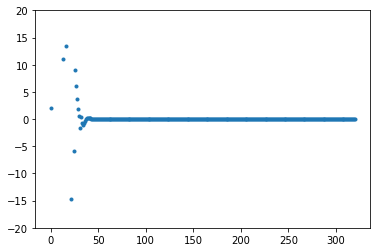

In [105]:
def testme():
    #data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.107-2021.json'
    #data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.095-2017.json'
    #data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.111-2018.json'
    data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.294-2018.json'
    phase_arr, n_inputs, time_vals, prog_arr = load_swarm_data(data_file)
    n_streams = phase_arr.shape[1] // n_inputs
    ph_eff_vals, pid_response  = sim_pid_loop(phase_arr, n_streams)
    metric_arr = np.zeros(5)
    metric_arr[0] = np.mean(ph_eff_vals)
    metric_arr[1] = np.mean(ph_eff_vals**2)
    metric_arr[2] = np.mean(ph_eff_vals > 0.875)
    metric_arr[3] = np.mean(ph_eff_vals > 0.75)
    metric_arr[4] = np.mean(ph_eff_vals > 0.5)
    print(metric_arr)
    eval_vals = (pid_response - np.diff(prog_arr, axis=0))
    eval_vals[eval_vals < -180.0] += 360.0
    eval_vals[eval_vals > 180.0] -= 360.0

    _ = plt.plot(eval_vals[:, -1], '.')
    _ = plt.ylim([-20, 20])

    print(ray.get(get_pid_metrics.remote(phase_arr, n_streams)))
%load_ext line_profiler
%lprun -f testme testme()

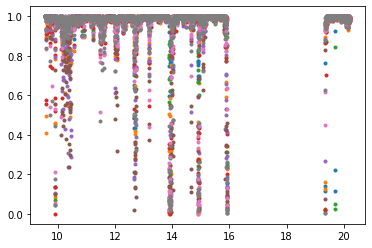

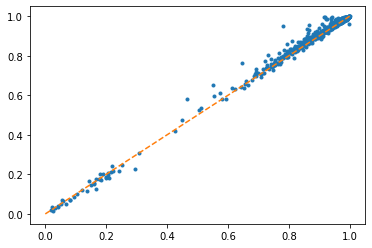

[0.49914335 0.66933181 0.5128498  0.66019417 0.72758424 0.74528841
 0.73272416 0.73615077]


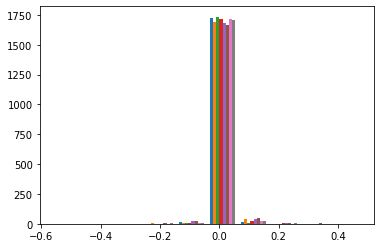

In [190]:
data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.106-2021.json'
phase_arr, n_inputs, time_vals, other_arr = load_swarm_data(data_file)
n_times = phase_arr.shape[0]
n_streams = phase_arr.shape[1] // n_inputs

ph_eff_vals, _  = sim_pid_loop(phase_arr, n_streams)
plt.plot(time_vals[1:], ph_eff_vals, '.')
plt.show()

ph_eff_vals2, _  = sim_pid_loop(phase_arr, n_streams, kp=0.80,ki=0.00, kd=0.1)
plt.plot(np.mean(ph_eff_vals**2.0,axis=1), np.mean(ph_eff_vals2**2.0,axis=1), '.')
plt.plot([0,1], [0,1],'--')
plt.show()

print(np.greater_equal(ph_eff_vals2, ph_eff_vals).mean(axis=0))
plt.hist(ph_eff_vals2**2.0 - ph_eff_vals**2.0)
plt.show()


In [151]:
%%time
#data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.095-2017.json'
data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.109-2021.json'
#data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.294-2018.json'

n_kp = 41
kp_range = [0.0, 2.0]
n_ki = 41
ki_range = [-1.0, 1.0]
n_kd = 41
kd_range = [-1.0, 1.0]

n_int = 1
int_start = 8
int_step = 3

phase_arr, n_inputs, time_vals, other_arr = load_swarm_data(data_file)
n_times = phase_arr.shape[0]
n_streams = phase_arr.shape[1] // n_inputs
phase_arr_id = ray.put(phase_arr)
pid_arr = {}
print("Processing", end="")
sys.stdout.flush()

for idx, kp in enumerate(np.linspace(kp_range[0], kp_range[1], num=n_kp)):
    for jdx, ki in enumerate(np.linspace(ki_range[0], ki_range[1], num=n_ki)):
        for kdx, kd in enumerate(np.linspace(kd_range[0], kd_range[1], num=n_kd)):
            for ldx, int_length in enumerate(np.arange(int_start, int_start + (int_step * n_int) , int_step)):
                pid_arr[get_pid_metrics.remote(
                    phase_arr_id, n_streams, int_length=int_length, kp=kp, ki=ki, kd=kd
                )] = (idx, jdx, kdx, ldx)
    print(".", end="")
    sys.stdout.flush()
print("complete!")

results_arr = np.zeros((n_kp, n_ki, n_kd, n_int, 10), dtype=np.float32)
print("Recording", end="")
sys.stdout.flush()
while pid_arr != {}:
    ready_ids, not_ready_ids = ray.wait(list(pid_arr.keys()), num_returns=n_ki*n_kd*n_int)
    for obj_id in ready_ids:
        results_arr[pid_arr[obj_id]] = ray.get(obj_id)
        del pid_arr[obj_id]
    print(".", end="")
    sys.stdout.flush()
print("complete!")


Processing.........................................complete!
Recording.........................................complete!
CPU times: user 1min 31s, sys: 1min 7s, total: 2min 39s
Wall time: 3min 38s


In [185]:
opt_sel = 0; opt_pos = np.where((results_arr[:,:,:,:,opt_sel]) == np.max((results_arr[:,:,:,:,opt_sel])))
#opt_pos = np.where((np.log(results_arr[:,:,:,:,2:8]).sum(axis=4)) == np.max((np.log(results_arr[:,:,:,:,2:8]).sum(axis=4))))
print(opt_pos)
kp_best = np.linspace(kp_range[0], kp_range[1], num=n_kp) [opt_pos[0][-1]]
ki_best = np.linspace(ki_range[0], ki_range[1], num=n_ki) [opt_pos[1][-1]]
kd_best = np.linspace(kd_range[0], kd_range[1], num=n_kd) [opt_pos[2][-1]]
int_best = np.arange(int_start, (int_start + int_step*n_int), int_step)[opt_pos[3][0]]
print("Best option @ %.5g pheff:\nkp=%g\nki=%g\nkd=%g\nint_best=%i" % (100.0*results_arr[:,:,:,:,opt_sel][opt_pos], kp_best,ki_best,kd_best,int_best))

(array([19]), array([20]), array([21]), array([0]))
Best option @ 35.458 pheff:
kp=0.95
ki=0
kd=0.05
int_best=8


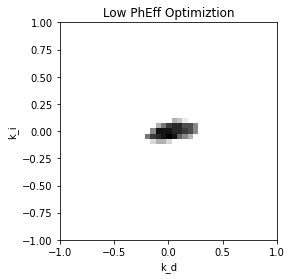

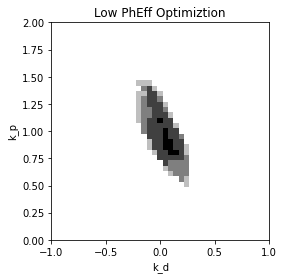

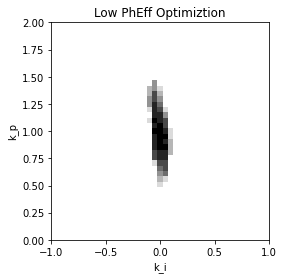

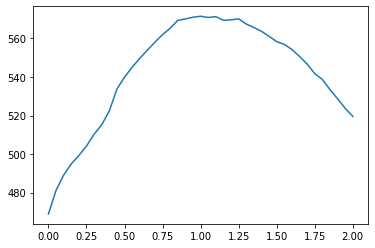

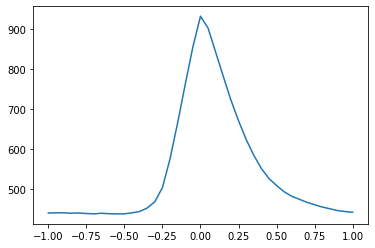

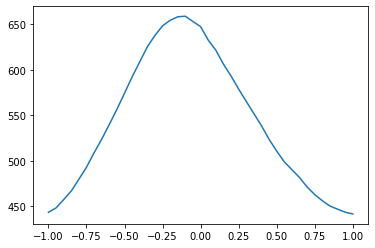

In [156]:
#results_sum = np.sum(np.sum(results_arr[:,:,:,0,:,:] > 0.9, axis=4), axis=3).astype(float)
results_sum = np.array(results_arr[:, :, :, 0, 5])
results_sum /= np.max(results_sum)

plt.imshow(1-np.mean(results_sum>0.95,axis=0), extent=np.array([kd_range, ki_range]).flatten(), origin='lower', cmap='gray')
plt.title('Low PhEff Optimiztion')
plt.xlabel('k_d')
plt.ylabel('k_i')
plt.show()

plt.imshow(1-np.mean(results_sum>0.95,axis=1), extent=np.array([kd_range, kp_range]).flatten(), origin='lower', cmap='gray')
plt.title('Low PhEff Optimiztion')
plt.xlabel('k_d')
plt.ylabel('k_p')
plt.show()

plt.imshow(1-np.mean(results_sum>0.95,axis=2), extent=np.array([ki_range, kp_range]).flatten(), origin='lower', cmap='gray')
plt.title('Low PhEff Optimiztion')
plt.xlabel('k_i')
plt.ylabel('k_p')
plt.show()

plt.plot(np.linspace(kp_range[0], kp_range[1], num=n_kp), results_sum.sum(axis=2).sum(axis=1))
plt.show()
plt.plot(np.linspace(ki_range[0], ki_range[1], num=n_ki), results_sum.sum(axis=2).sum(axis=0))
plt.show()
plt.plot(np.linspace(kd_range[0], kd_range[1], num=n_kd), results_sum.sum(axis=1).sum(axis=0))
plt.show()

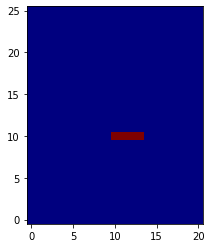

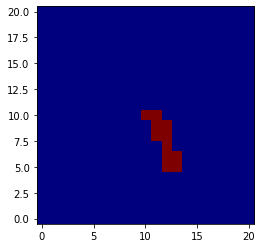

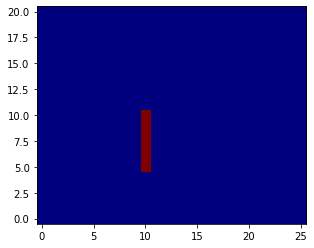

In [38]:
data = np.load('/Users/gkeating/test.npy')
data = np.sum(np.sum(data > 0.75, axis=5), axis=4).astype(float)
data /= data.max()
data = data[:,:,:,0]

plt.imshow(np.any(data > 0.999,axis=0), origin='lower', cmap='jet')
plt.clim([0,1])
plt.show()
plt.imshow(np.any(data > 0.999,axis=1), origin='lower', cmap='jet')
plt.clim([0,1])
plt.show()
plt.imshow(np.any(data > 0.999,axis=2), origin='lower', cmap='jet')
plt.clim([0,1])
plt.show()
#plt.plot((data > 0.9).sum(axis=5).sum(axis=4).sum(axis=2).sum(axis=1).sum(axis=0))

In [2]:
import glob
data_path = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/'
file_list = glob.glob(data_path + '/*')

for file in file_list:
    try:
        phase_data = load_swarm_data(file)
        print(phase_data.shape, file)
    except:
        print(file)


(4258, 56, 3)
(3900, 56, 3)
(3, 64, 3)
(3093, 48, 3)
(3410, 56, 3)
(5693, 48, 3)
